# ノート 3: 古典的 ML の復習

### 目標: ランダムフォレストを例に古典的 ML の復習をする

### 背景

ML モデルを利用する場合、作成したモデルを別の基準となるモデルと比較するとよいです。
このチュートリアルでは、複雑な構造を持つニューラルネットワークを使った ML に挑戦します。
Part1 で学習させた古典的 ML モデルを基準にして、ニューラルネットワークモデルの性能を比較します。
論文でも述べましたが、ニューラルネットワークの学習をチュートリアルで実行できるようにするため、
オリジナルのデータセットの解像度を落としてデータサイズを小さくした sub-SEVIR データセットを使います。
sub-SEVIR データセットは Part1 で使ったオリジナルの解像度のデータより情報量が少なくなっていることに注意してください。

これを考慮するため Part1 で使ったパーセンタイル値を特徴量として
sub-SEVIR データセットから計算したデータをあらかじめ用意してあります。
このノートでは sub-SEVIR データセットから Part1 と同じ古典的 ML モデルの学習と評価を行います。
scikit-learn の使い方のよい復習にもなるでしょう。


### Step 1: インポート


In [1]:
import warnings
warnings.filterwarnings("ignore") # 不要な警告の抑止

from pprint import pprint
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ユーティリティ関数へのパス
sys.path.insert(1, "../scripts/")

# jupyterのカスタマイズ
%config InlineBackend.figure_format = 'retina'

### Step 2: データの読み込み

sub-SEVIR データセットのパーセンタイル値のデータを読み込みます。


In [2]:
from pathlib import Path

save_dir = Path("../datasets/sub-sevir-engineered")
# 訓練データ
df_t = pd.read_csv(save_dir / "lowres_features_train.csv")
# 評価データ
df_v = pd.read_csv(save_dir / "lowres_features_val.csv")

df_t

,q000_ir,q001_ir,q010_ir,q025_ir,q050_ir,q075_ir,q090_ir,q099_ir,q100_ir,q000_wv,...,q001_vl,q010_vl,q025_vl,q050_vl,q075_vl,q090_vl,q099_vl,q100_vl,label_class,label_reg
0,-2.196238,-1.949695,-1.791281,-1.528253,-1.010820,0.495947,1.456004,1.500297,1.509985,-3.016850,...,-0.206396,-0.206396,-0.206396,-0.206396,0.029683,0.789612,7.986002,24.557011,1.0,600.0
1,-2.097033,-1.949780,-1.785856,-1.546079,-0.995319,0.398583,1.445153,1.498747,1.511147,-2.861186,...,-0.206396,-0.206396,-0.206396,-0.206396,0.023692,0.789612,6.997860,23.928528,1.0,555.0
2,-2.191200,-1.950458,-1.779152,-1.547726,-1.009851,0.329993,1.425157,1.496798,1.508822,-3.032837,...,-0.206396,-0.206396,-0.206396,-0.206396,0.017852,0.834176,7.185461,23.316002,1.0,486.0
3,-2.069906,-1.953159,-1.768301,-1.545692,-0.995707,0.253361,1.396985,1.494484,1.504172,-2.798920,...,-0.206396,-0.206396,-0.206396,-0.206396,0.012161,0.807767,6.642037,24.557011,1.0,356.0
4,-2.038905,-1.955155,-1.766751,-1.539879,-0.963930,0.217225,1.364627,1.492547,1.506885,-2.714777,...,-0.206396,-0.206396,-0.206396,-0.206396,0.017852,0.861273,8.199336,22.719021,1.0,416.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,-1.797481,-1.756005,-1.633949,-1.518081,-1.326841,-0.951142,-0.594974,-0.133138,0.101357,-2.148497,...,-0.183930,-0.144616,-0.127766,-0.099991,-0.045853,0.035831,0.178063,0.291140,0.0,0.0
59996,-1.791669,-1.759493,-1.635886,-1.520793,-1.335366,-0.955986,-0.572343,-0.065156,0.080043,-2.162801,...,-0.183930,-0.144616,-0.127766,-0.097220,-0.045853,0.042138,0.178356,0.389232,0.0,0.0
59997,-1.805232,-1.764918,-1.637049,-1.519437,-1.333816,-0.968774,-0.581837,-0.085438,0.117633,-2.181313,...,-0.206396,-0.144616,-0.127766,-0.097220,-0.045853,0.029683,0.188375,0.345023,0.0,0.0
59998,-1.796706,-1.757168,-1.637979,-1.526606,-1.336722,-0.984953,-0.574862,-0.046849,0.077331,-2.172899,...,-0.206396,-0.144616,-0.127766,-0.094377,-0.041672,0.035831,0.209202,0.404742,0.0,0.0


このデータフレームは特徴量が `q_***_var` の列に格納されています。
`***` の部分がパーセンタイル値、`_var` が変数の種類（赤外、可視、水蒸気画像と VIL）を表します。
一番右の列がラベルで `label_class` が分類問題のラベル（発雷の有無）、`label_reg` が回帰問題のラベル（発雷の数）です。

IR 画像輝度温度の最小値（`q000_ir`）のヒストグラムを描いてみましょう。


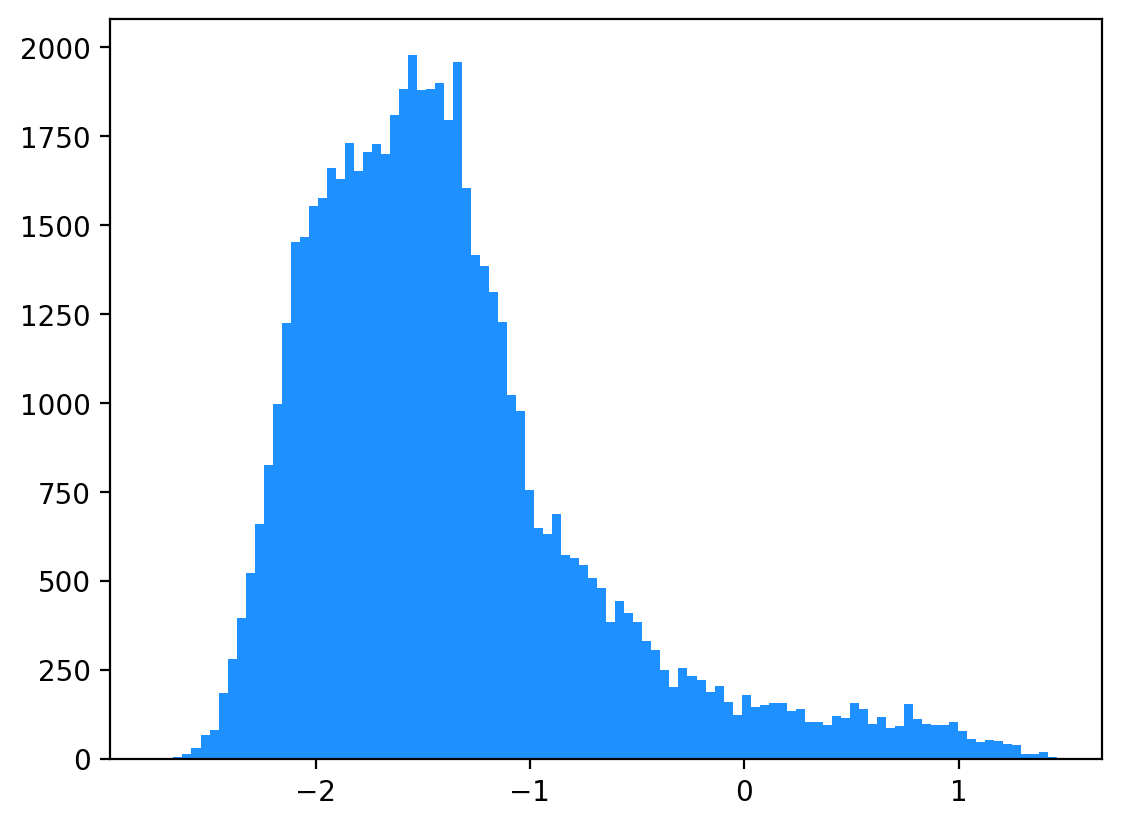

In [3]:
_ = plt.hist(df_t.q000_ir, bins=100, color="dodgerblue")

x 軸の単位が輝度温度ではないのは読み込んだデータが正規化してあるからです。
Part1 で学んだように値の変動が大きな特徴量に対してモデルがバイアスを持たないように正規化をしています。


モデルの学習を行う前に scikit-learn のモデルクラスで扱うために 入力特徴量 `X` とラベル `y` の NumPy 配列に分割します。
これでデータの前処理は完了です。


In [4]:
X_t = df_t.iloc[:, :36].to_numpy()
y_t = df_t.iloc[:, 36].to_numpy()  # 36番目の列（右から2番目）が分類問題のラベル
X_v = df_v.iloc[:, :36].to_numpy()
y_v = df_v.iloc[:, 36].to_numpy()

### Step 3: 分類問題モデルの学習

Part1 で使ったモデル（ロジスティック回帰、単純ベイズ、決定木、ランダムフォレスト、勾配ブースト決定木）
を使ってモデルの学習を行います。

Part1 で学習した scikit-learn の使い方を思い出してください。全てのモデルは同じ実行方法で学習させることができるのでした。
まずはモデルの初期化です。


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB


model_list = [
    LogisticRegression(),
    GaussianNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    LinearSVC(dual=False),
]

pprint(model_list)

[LogisticRegression(),
 GaussianNB(),
 DecisionTreeClassifier(),
 RandomForestClassifier(),
 GradientBoostingClassifier(),
 LinearSVC(dual=False)]


訓練データで学習させます。学習には少し時間がかかります。


In [6]:
import tqdm  # ループの進行状況を表示するパッケージ

for model in tqdm.tqdm(model_list):
    model.fit(X_t, y_t)

100%|██████████| 6/6 [00:59<00:00,  9.98s/it]


### Step 4: モデルの評価

学習が完了したら次はモデルの評価です。Part1 で学んだ ROC 曲線とパフォーマンスダイアグラムを思い出しましょう。
同じコードを使ってプロットします。

まずはパフォーマンスダイアグラムです。


LgR accuracy: 89.0%
LgR CSI: 0.81
NB accuracy: 85.0%
NB CSI: 0.76
DT accuracy: 86.0%
DT CSI: 0.77
RF accuracy: 90.0%
RF CSI: 0.83
GBT accuracy: 90.0%
GBT CSI: 0.84
SVM accuracy: 89.0%
SVM CSI: 0.81


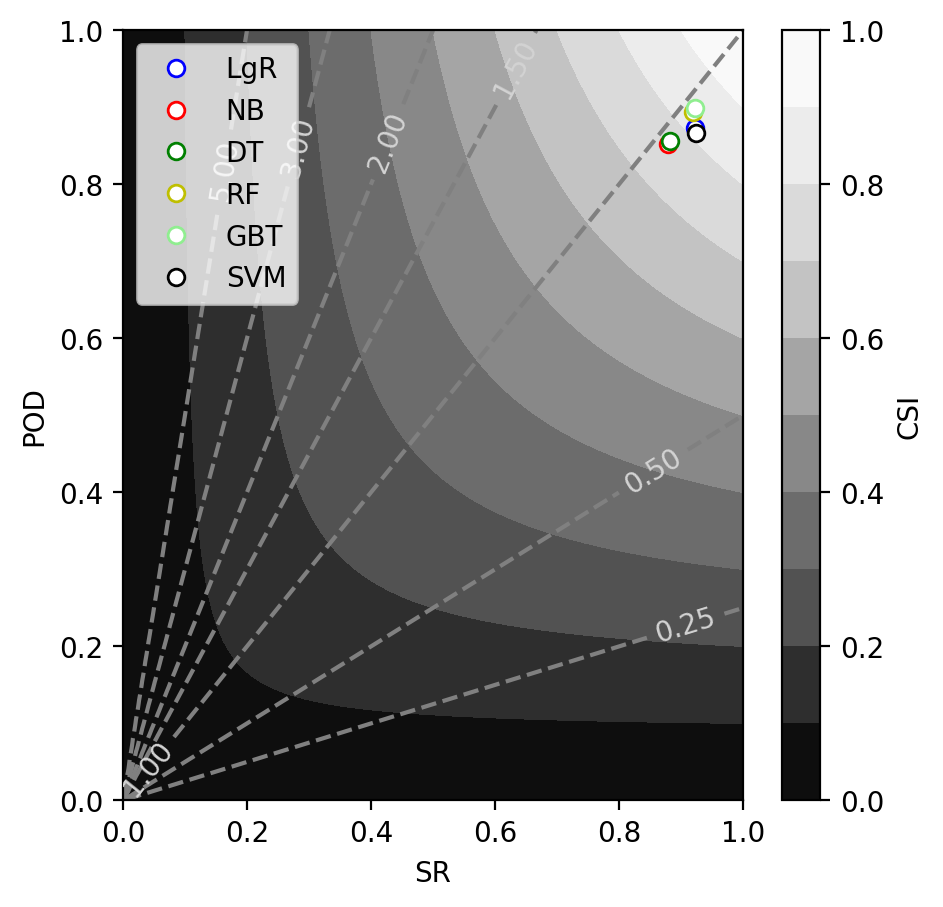

In [7]:
# ユーティリティ関数の読み込み
from gewitter_functions import (
    get_contingency_table,
    make_performance_diagram_axis,
    get_acc,
    get_pod,
    get_sr,
    csi_from_sr_and_pod,
)


def plot_performance_diagram_classification(model_list):
    # パフォーマンスダイアグラムのAxesオブジェクト
    ax = make_performance_diagram_axis()

    # 色とラベルのリスト
    colors = ["b", "r", "g", "y", "LightGreen", "k"]
    legend_labels = ["LgR", "NB", "DT", "RF", "GBT", "SVM"]

    for idx, model in enumerate(model_list):
        # 評価データからの予測
        yhat = model.predict(X_v)
        # 分割表を計算
        cont_table = get_contingency_table(yhat, y_v)

        # 指標を求める
        accuracy = get_acc(cont_table)
        pod = get_pod(cont_table)
        sr = get_sr(cont_table)
        csi = csi_from_sr_and_pod(sr, pod)

        ax.plot(sr, pod, "o", c=colors[idx], mfc="w", label=legend_labels[idx])
        print("{} accuracy: {}%".format(legend_labels[idx], np.round(accuracy, 0)))
        print("{} CSI: {}".format(legend_labels[idx], np.round(csi, 2)))

    ax.legend()


plot_performance_diagram_classification(model_list)

パフォーマンスダイアグラムは右上ほどよい性能であることを示します。
単純なモデル（LgR と NB）とその他のモデルで少し差がありますが、どのモデルもよい性能であることが分かります。

高解像度の SEVIR データを使って学習させた Part 1 ノート 8 の図と比較してみましょう。

<img src="../images/Part1_Performance_Diagram.png"
     alt="PerformancePart1"
     width=350 />

おおむねよい対応をしています。sub-SEVIR データセットの方が若干よい性能を示しているのはデータサイズが小さいからだと考えられます。

次に ROC 曲線をプロットします。


LgR AUC: 0.96
NB AUC: 0.91
DT AUC: 0.86
RF AUC: 0.96
GBT AUC: 0.97


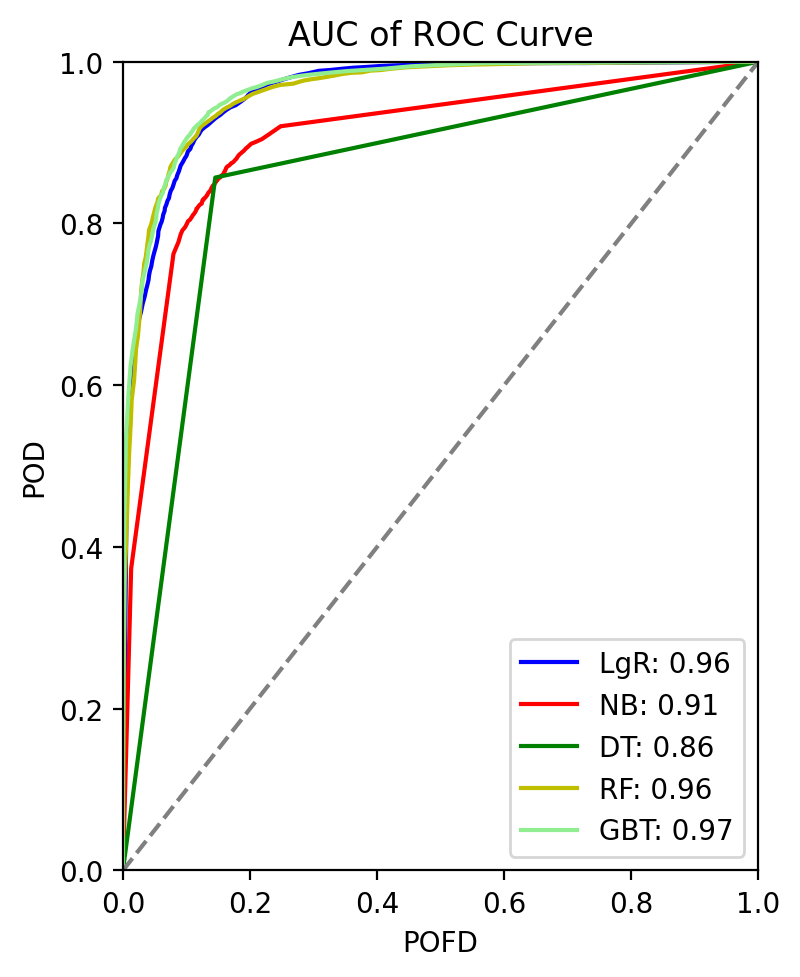

In [8]:
# ユーティリティ関数
from gewitter_functions import get_points_in_roc_curve, get_area_under_roc_curve


def plot_roc_classification(model_list):
    fig, ax = plt.subplots(figsize=(4.1, 5))

    # プロットの色とラベル
    colors = ["b", "r", "g", "y", "LightGreen", "k"]
    legend_labels = ["LgR", "NB", "DT", "RF", "GBT", "SVM"]

    for idx, model in enumerate(model_list[:-1]):
        # 評価データからの予測される分類確率
        yhat_proba = model.predict_proba(X_v)

        # クラス1の予測でプロット（2分類問題なのでクラス0とクラス1の確率の和は1）
        y_preds = yhat_proba[:, 1]

        # ROC曲線の計算
        pofds, pods = get_points_in_roc_curve(
            forecast_probabilities=y_preds,
            observed_labels=y_v,
            threshold_arg=np.linspace(0, 1, 100),
        )
        # AUCの計算
        auc = get_area_under_roc_curve(pofds, pods)

        ax.plot(
            pofds,
            pods,
            "-",
            color=colors[idx],
            label=f"{legend_labels[idx]}: {np.round(auc, 2)}",
        )

        print("{} AUC: {}".format(legend_labels[idx], np.round(auc, 2)))

    ax.legend()

    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    ax.plot([0, 1], [0, 1], "--", color="Grey")

    ax.set_title("AUC of ROC Curve")
    ax.set_xlabel("POFD")
    ax.set_ylabel("POD")

    fig.tight_layout()


plot_roc_classification(model_list)

高解像度の SEVIR データを使って学習させた Part 1 ノート 8 の図と比較してみましょう。

<img src="../images/Part1_ROC_Diagram.png"
     alt="PerformancePart1"
     width=350 />

パフォーマンスダイアグラムと同じく sub-SEVIR データの方が Part1 の高解像度データより精度がよくなっています。


### Step 5: 回帰モデルの学習

回帰問題の場合はデータの前処理を追加で行います。Part1 で発雷なしのデータをあらかじめ取り除いて学習を行いました。
sub-SEVIR データセットについても同じ処理を行いましょう。


In [9]:
from pathlib import Path

save_dir = Path("../datasets/sub-sevir-engineered")
# 訓練データ
df_t = pd.read_csv(save_dir / "lowres_features_train.csv")
# 評価データ
df_v = pd.read_csv(save_dir / "lowres_features_val.csv")
df_t.head()

# ラベル（発雷数）が0のデータを除く
df_t = df_t.where(df_t.label_reg > 0).dropna()
df_v = df_v.where(df_v.label_reg > 0).dropna()

df_t

,q000_ir,q001_ir,q010_ir,q025_ir,q050_ir,q075_ir,q090_ir,q099_ir,q100_ir,q000_wv,...,q001_vl,q010_vl,q025_vl,q050_vl,q075_vl,q090_vl,q099_vl,q100_vl,label_class,label_reg
0,-2.196238,-1.949695,-1.791281,-1.528253,-1.010820,0.495947,1.456004,1.500297,1.509985,-3.016850,...,-0.206396,-0.206396,-0.206396,-0.206396,0.029683,0.789612,7.986002,24.557011,1.0,600.0
1,-2.097033,-1.949780,-1.785856,-1.546079,-0.995319,0.398583,1.445153,1.498747,1.511147,-2.861186,...,-0.206396,-0.206396,-0.206396,-0.206396,0.023692,0.789612,6.997860,23.928528,1.0,555.0
2,-2.191200,-1.950458,-1.779152,-1.547726,-1.009851,0.329993,1.425157,1.496798,1.508822,-3.032837,...,-0.206396,-0.206396,-0.206396,-0.206396,0.017852,0.834176,7.185461,23.316002,1.0,486.0
3,-2.069906,-1.953159,-1.768301,-1.545692,-0.995707,0.253361,1.396985,1.494484,1.504172,-2.798920,...,-0.206396,-0.206396,-0.206396,-0.206396,0.012161,0.807767,6.642037,24.557011,1.0,356.0
4,-2.038905,-1.955155,-1.766751,-1.539879,-0.963930,0.217225,1.364627,1.492547,1.506885,-2.714777,...,-0.206396,-0.206396,-0.206396,-0.206396,0.017852,0.861273,8.199336,22.719021,1.0,416.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59959,-1.032521,-0.928654,-0.665154,-0.471104,0.083725,0.669458,0.792185,0.993013,1.103866,-0.644867,...,-0.206396,-0.206396,-0.206396,-0.206396,-0.206396,-0.183930,0.343028,3.683830,1.0,1.0
59960,-1.035621,-0.940175,-0.675694,-0.477304,0.045942,0.654733,0.788814,0.985158,1.099991,-0.629721,...,-0.206396,-0.206396,-0.206396,-0.206396,-0.206396,-0.178314,0.278144,5.815999,1.0,2.0
59961,-1.036008,-0.948325,-0.674725,-0.491546,0.012228,0.622278,0.788581,0.989397,1.115104,-0.699559,...,-0.206396,-0.206396,-0.206396,-0.206396,-0.206396,-0.178314,0.583286,7.383726,1.0,1.0
59962,-1.067785,-0.951882,-0.686738,-0.494258,-0.031174,0.597089,0.765718,0.972885,1.125955,-0.691986,...,-0.206396,-0.206396,-0.206396,-0.206396,-0.206396,-0.167081,0.647247,6.820372,1.0,3.0


scikit-learn で扱うために `X` と `y` の NumPy 配列に直します。回帰問題のラベルを出力に使うので 37 番目の列を使うことに注意してください。


In [10]:
X_t = df_t.iloc[:, :36].to_numpy()
y_t = df_t.iloc[:, 37].to_numpy()
X_v = df_v.iloc[:, :36].to_numpy()
y_v = df_v.iloc[:, 37].to_numpy()

モデルを初期化します。


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR

model_list = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    LinearSVR(),
]

pprint(model_list)

[LinearRegression(),
 DecisionTreeRegressor(),
 RandomForestRegressor(),
 GradientBoostingRegressor(),
 LinearSVR()]


学習させます。


In [12]:
for model in tqdm.tqdm(model_list):
    model.fit(X_t, y_t)

100%|██████████| 5/5 [01:40<00:00, 20.04s/it]


### Step 6: モデルの評価

Part1 と同じ図を作成しましょう。まずは密度表示付きの散布図を描きます。


In [13]:
# ユーティリティ関数
from aux_functions import boxbin, make_colorbar


def plot_scatter_regression(model_list):
    fig, axes = plt.subplots(2, 3, figsize=(7.5, 5))

    # 散布図の密度は33分割して計算
    n = 33
    xbins = np.logspace(0, 3.5, n)
    ybins = np.logspace(0, 3.5, n)

    # 色とラベル
    labels = ["LnR", "DT", "RF", "GBT", "SVM"]
    colors = ["r", "b", "orange", "purple", "dimgrey"]
    cmaps = ["Reds_r", "Blues_r", "Oranges_r", "Purples_r", "Greys_r"]

    # Axesのリストをループしやすいように変形
    axes = axes.ravel()

    # draw a new axis for a new colorbar to go on
    ax_cbar = fig.add_axes([0.75, 0.15, 0.015, 0.33])
    # draw that colorbar
    cbar = make_colorbar(ax_cbar, 0, 2, plt.cm.Greys_r)
    # label that colorbar
    cbar.set_label("$\%$ of total points")

    for i, ax in enumerate(axes[:5]):
        # ログスケールにする
        ax.semilogy()
        ax.semilogx()

        # 評価データから予測
        model = model_list[i]
        yhat = model.predict(X_v)

        # 散布図
        ax.scatter(yhat, y_v, color=colors[i], s=1, marker="+")

        # 密度をプロット
        ax, cbar, _ = boxbin(
            yhat,
            y_v,
            xbins,
            ybins,
            ax=ax,
            mincnt=10,
            normed=True,
            cmap=cmaps[i],
            vmin=0,
            vmax=2,
            cbar=False,
        )

        # 軸とメモリの設定
        ax.set_xlim([1, 4000])
        ax.set_xticks([1, 10, 100, 1000])
        ax.set_yticks([1, 10, 100, 1000])
        ax.set_ylim([1, 4000])

        # 対角線
        ax.plot([1, 4000], [1, 4000], "--k", alpha=0.5)

        ax.set_title(labels[i])

    axes[5].axis("off")  # 6番目のAxesは描画しない
    axes[0].set_ylabel(r"$y$, [# of flashes]")
    axes[3].set_ylabel(r"$y$, [# of flashes]")
    axes[4].set_xlabel(r"$\hat{y}$, [# of flashes]")

    fig.tight_layout()

n_samples= 4154.0
n_samples= 5131.0
n_samples= 5649.0
n_samples= 5679.0
n_samples= 4500.0


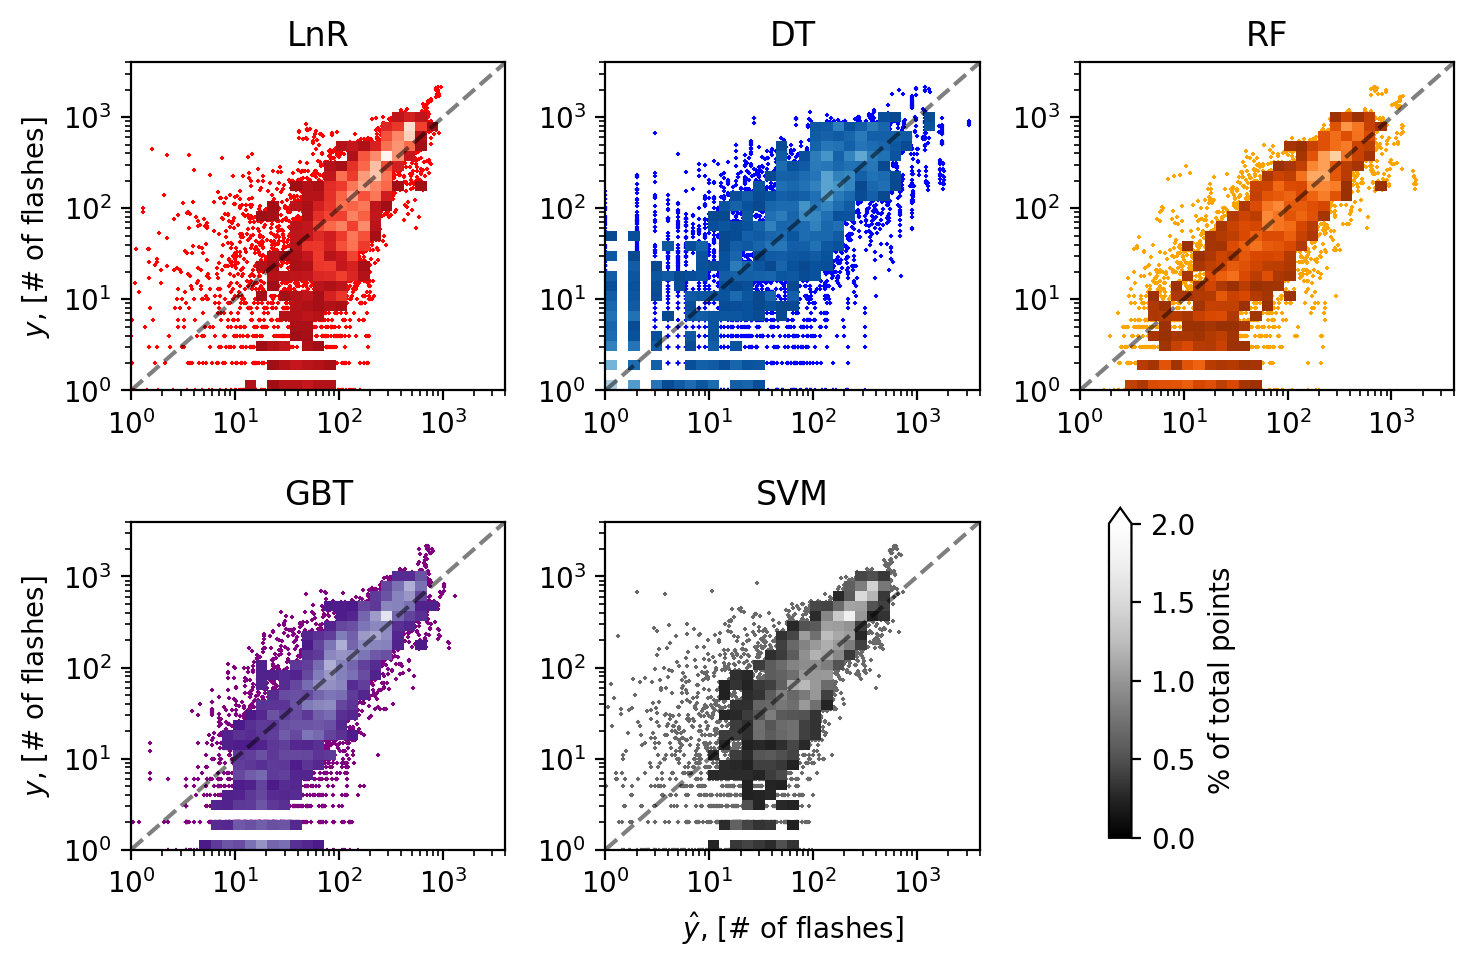

In [14]:
plot_scatter_regression(model_list)

Part1 ノート 8 の図と比べてみましょう。

<img src="../images/Part1_one2one.png" alt="PerformancePart1" width=550/>

データセットのサイズが大きく異なるので定性的な比較のみを行います。
結果はおおむね同じで低解像度のデータ（sub-SEVIR）でも ML はよいスキルを示しています。

予測指標も比較してみましょう。


In [15]:
# ユーティリティ関数
from gewitter_functions import get_mae, get_rmse, get_bias, get_r2


def plot_metrics_regression(model_list):
    fig, axes = plt.subplots(2, 2, figsize=(5, 5))

    labels = ["LnR", "DT", "RF", "GBT", "SVM"]
    colors = ["r", "b", "orange", "purple", "dimgrey"]
    labels = ["LnR", "DT", "RF", "GBT", "SVM"]

    for i, model in enumerate(model_list):
        # 評価データからの予測
        yhat = model.predict(X_v)
        # 指標
        mae = get_mae(y_v, yhat)
        rmse = get_rmse(y_v, yhat)
        bias = get_bias(y_v, yhat)
        r2 = get_r2(y_v, yhat)

        ############### subplot 0,0: Bias ########################
        ax = axes[0, 0]
        # 棒グラフの位置をモデル毎にずらす
        ax.bar(i, bias, width=0.95, color=colors[i])
        # 値をテキストでプロット
        annotate = str(int(np.round(bias))).rjust(3, " ")
        ax.text(i - 0.4, bias + 5, annotate)

        ####### subplot 0,1: Mean Absolute Error #################
        ax = axes[0, 1]
        ax.bar(i, mae, width=0.95, color=colors[i])
        annotate = str(int(np.round(mae))).rjust(3, " ")
        ax.text(i - 0.4, mae + 5, annotate)

        ####### subplot 1,0: Root Mean Squared Error #############
        ax = axes[1, 0]
        ax.bar(i, rmse, width=0.95, color=colors[i])
        annotate = str(int(np.round(rmse))).rjust(3, " ")
        ax.text(i - 0.4, rmse + 5, annotate)

        ####### subplot 1,1: Rsquared ###########################
        ax = axes[1, 1]
        ax.bar(i, r2, width=0.95, color=colors[i])
        annotate = str(np.round(r2, 2)).ljust(4, "0")
        ax.text(i - 0.5, r2 + 0.05, annotate)

    ax = axes[0, 0]
    ax.xaxis.set_ticks(np.arange(0, 5))
    ax.xaxis.set_ticklabels(labels, rotation=45)
    ax.set_ylim([-130, 130])
    ax.set_title("Bias")

    ax = axes[0, 1]
    ax.set_ylim([0, 200])
    ax.xaxis.set_ticks(np.arange(0, 5))
    ax.xaxis.set_ticklabels(labels, rotation=45)
    ax.set_title("Mean Abs. Error")

    ax = axes[1, 0]
    ax.set_ylim([0, 300])
    ax.xaxis.set_ticks(np.arange(0, 5))
    ax.xaxis.set_ticklabels(labels, rotation=45)
    ax.set_title("Root Mean Sq. Error")

    ax = axes[1, 1]
    ax.set_ylim([-1, 1])
    ax.xaxis.set_ticks(np.arange(0, 5))
    ax.xaxis.set_ticklabels(labels, rotation=45)
    ax.set_title("$R^{2}$")

    fig.tight_layout()

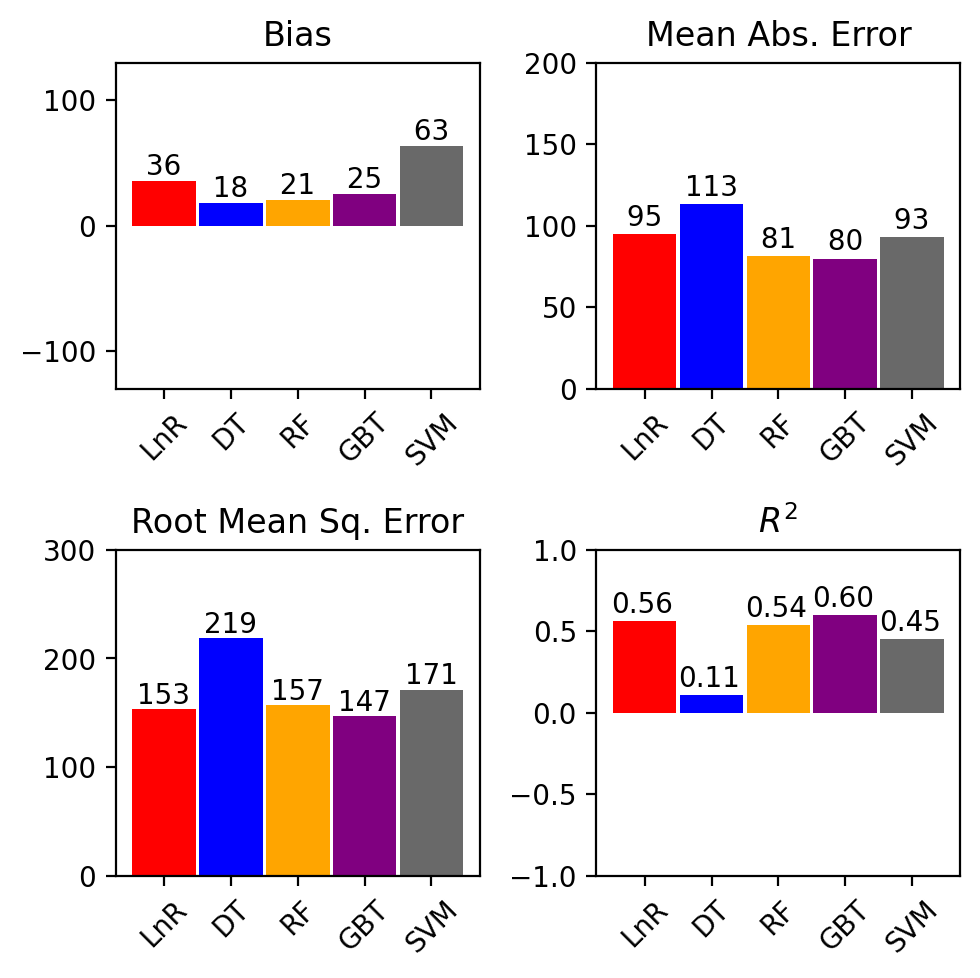

In [16]:
plot_metrics_regression(model_list)

Part1 と比較します。

<img src="../images/Part1_barcharts.png" alt="PerformancePart1" width=350 />

定量的な比較をすると誤差は Part1 より大きくなっていますがほぼ同じ結果が得られました。


#### sub-SEVIR データでモデルを再学習したのはなぜか

Part1 の結果と比較しながらモデルの再学習を行ったのはなぜでしょうか？
Part2 で使う sub-SEVIR データは Part1 の高解像度データと同じ情報量を持ったデータセットではありません。
このため、再学習を行わずにこれから学習を行うニューラルネットワークの予測性能と Part1 の古典的 ML の予測性能を比較するのは公正ではなく、
ニューラルネットワークを含めた ML 手法の優劣を比較することは難しいでしょう。

このノートで再学習を行ったことにより古典的 ML との比較の基準を作成することができました。
次のノートから ニューラルネットワークのパッケージを使ってより複雑な ML に挑戦しましょう。
